<a href="https://colab.research.google.com/github/ShaikShareenaBhanu/NGCF_LightGCN_Analysis/blob/main/gnn_using_PyG_Movielens_2023_04_28_19_33_28_932.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch-scatter
!pip install --upgrade torch-sparse
!pip install --upgrade torch-cluster
!pip install --upgrade torch-spline-conv
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.1-cp39-cp39-linux_x86_64.whl size=484407 sha256=b345cb7e2f7bc9de0cfecde47ef764e0f5618e099d803dc3adfdb6be5a9eb21e
  Stored in directory: /root/.cache/pip/wheels/d5/0c/18/11b4cf31446c5d460543b0fff930fcac3a3f8a785e5c73fb15
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 KB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.17-cp39-cp39-linux_x86_64.whl size=1082789 sha256=13be38d19f14e0862798ce958f74c8e573c569be06fcbd2398239135fd61085d
  Stored in directory: /root/.cache/pip/wheels/f8/43/54/bcb8acdd1109

In [ ]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [ ]:
torch_geometric.__version__

'2.2.0'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Dataset and Preprocessing
For this tutorial, we’ll be using the MovieLens 100K dataset, which contains 100,000 ratings by 943 users of 1682 items (movies). To ensure the quality of the dataset, each user has rated at least 20 movies.

We’ll focus on the interactions between users and items, in this case user ratings of movies, but the dataset also provides metadata about users and movies, such as user demographics and movie titles, release dates, and genres. T

The user ratings of movies form a bipartite graph, which we can apply graph machine learning methods to recommend new movies to users.

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2023-02-28 04:04:27--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  24.0MB/s    in 0.2s    

2023-02-28 04:04:27 (24.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [ ]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("ml-100k/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.head(5))


100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


We only want to use high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [ ]:
# How many ratings are a 3 or above?
df = df[df['rating']>=3]
print(len(df))

82520


In [ ]:
# What's the distribution of highly rated movies?
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [ ]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [ ]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  66016
Test Size :  16504


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [ ]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['item_id'].isin(train_item_ids))
]
print(len(test))

943 1546
16504


In [ ]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [ ]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1546


Minibatch Sampling
Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add n_usr to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

Edge Index
PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add n_users to the item tensor to ensure that every node in the graph has a unique identifier.

In [ ]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 769,  168,  326,  ..., 1683, 2006,  989],
        [1192, 1272, 1085,  ...,  601,  621,   59]])

Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.



In [ ]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([989,  59]), tensor([ 769, 1192]))

In [ ]:
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([ 59, 989]), tensor([1192,  769]))

Model Architecture First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.





LightGCN Convolutional Layer The LightGCN architecture is governed by the following rules:

e(k+1)u=∑i∈Nu1|Nu|−−−−√|Ni|−−−√e(k)i

e(k+1)i=∑u∈Ni1|Ni|−−−√|Nu|−−−−√e(k)u In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.



Briefly explain how the MessagePassing class works (look at colabs)

We can specify the type of aggregation our MessagePassing layer should use by passing in an aggr= argument in the layer initialization. Here we use add to specify summation aggregation of messages.

Note that we could have manually defined our aggregation function by defining a function explicitly in the class:

def aggregate(self, x, messages, index): return torch_scatter.scatter(messages, index, self.node_dim, reduce="sum") The torch_scatter.scatter function enables us to aggregate messages being sent to the same node. The reduce= argument specifies how to aggregate, while index has the same length as the messages tensor and maps from message to destination node.



In [ ]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

Let's test out our implementation of the LightGCN convolution by applying it to a small bipartite graph.

This sample graph is undirected, and node 0 is connected to nodes 2 and 3 while node 1 is connected to 3 and 4.

In [ ]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [ ]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

Recommender System GNN
For this tutorial, we will be using the following class, RecSysGNN in order to stack the NGCF or LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are n-hops away in a model that uses n layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's n-hop neighborhood, so they need to be propagated as well.

In [ ]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

Loss function and metrics
We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [ ]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

Train and evaluate models
Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [ ]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [ ]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

Train and eval LightGCN

In [ ]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

In [ ]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

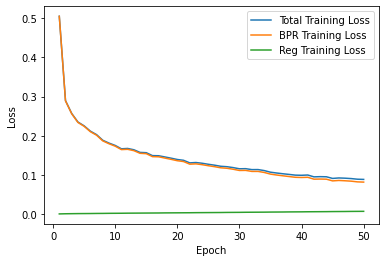

In [ ]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

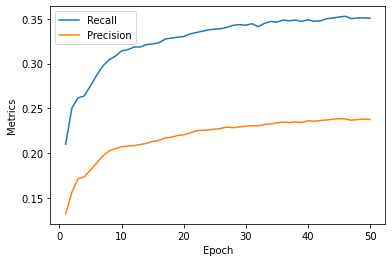

In [ ]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

Train and eval NGCF

In [ ]:
ngcf = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([2489, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [ ]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]
epoch_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

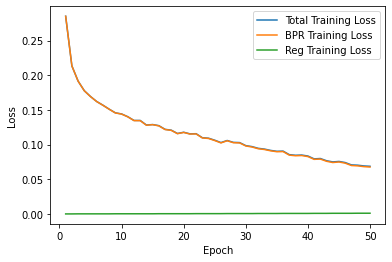

In [ ]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

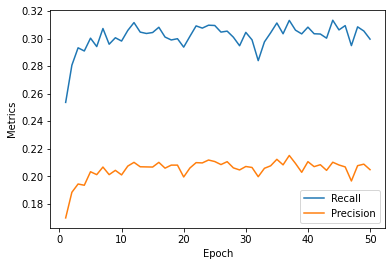

In [ ]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

Compare model performance of NGCF and LightGCN

In [ ]:
max(light_precision), max(light_recall)

(0.2386, 0.3529)

In [ ]:
max(ngcf_precision), max(ngcf_recall)

(0.2152, 0.3133)

Paper References
Harper, F. Maxwell, and Konstan, Joseph A. “The MovieLensDatasets: History and Context.” ACM Transactions on Interactive Intelligence Systems (TiiS) 5, 4. 2015.
He, Xiangnan, et al. “LightGCN: Simplifying and powering graph convolution network for recommendation.” Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2020.
Wang, Xiang, et al. “Neural graph collaborative filtering.” Proceedings of the 42nd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2019.
Code References
We thank the authors of the following codebases and notebooks, from which parts of this tutorial were inspired or adapted.

https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

https://github.com/gusye1234/LightGCN-PyTorch

https://github.com/SytzeAndr/NGCF_RP32/blob/hand-in/NGCF.ipynb